## 1. Loading in the data

In this lab we will continue working the transcripts of the State of the Union addresses. This time we will build a type of "social network" of who refers to whom. We'll first restrict to the presidents themselves, and then expand the set of people. We'll get some more practice with the skills used in the Gutenberg books, and see how to draw certain types of networks in Python.

In [1]:
from datascience import *
import numpy as np
import re

# direct plots to appear within the cell, and set their style
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')


In [2]:
import json
with open('transcripts.json') as f:
    data = json.load(f)
    
import datetime

dates = []
presidents = []
transcripts = []
years = []

for a in np.arange(len(data)):
    dates.append(data[a]['date'])
    presidents.append(data[a]['president'])
    transcripts.append(data[a]['transcript'])
    year = datetime.datetime.strptime(data[a]['date'], "%Y-%m-%d").year
    years.append(year)

speeches = Table().with_columns('Date', dates, 'Year', years, 'President', presidents, 'Transcript', transcripts)
speeches = speeches.sort('Date', descending=True)
speeches.show(16)
speeches.sort('Date', descending=False).show(16)

Date,Year,President,Transcript
2019-02-05,2019,Donald J. Trump,"Madam Speaker, Mr. Vice President, Members of Congress, ..."
2018-01-30,2018,Donald J. Trump,"Mr. Speaker, Mr. Vice President, Members of Congress, th ..."
2017-02-28,2017,Donald J. Trump,"Thank you very much. Mr. Speaker, Mr. Vice President, Me ..."
2016-01-12,2016,Barack Obama,"Thank you. Mr. Speaker, Mr. Vice President, Members of C ..."
2015-01-20,2015,Barack Obama,"The President. Mr. Speaker, Mr. Vice President, Members ..."
2014-01-28,2014,Barack Obama,"The President. Mr. Speaker, Mr. Vice President, Members ..."
2013-02-12,2013,Barack Obama,"Please, everybody, have a seat. Mr. Speaker, Mr. Vice Pr ..."
2012-01-24,2012,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Congress, di ..."
2011-01-25,2011,Barack Obama,"Mr. Speaker, Mr. Vice President, Members of Congress, di ..."
2010-01-27,2010,Barack Obama,"Madam Speaker, Vice President Biden, Members of Congress ..."


Date,Year,President,Transcript
1790-01-08,1790,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1790-12-08,1790,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1791-10-25,1791,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1792-11-06,1792,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1793-12-03,1793,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1794-11-19,1794,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1795-12-08,1795,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1796-12-07,1796,George Washington,Fellow-Citizens of the Senate and House of Representativ ...
1797-11-22,1797,John Adams,Gentlemen of the Senate and Gentlemen of the House of Re ...
1798-12-08,1798,John Adams,Gentlemen of the Senate and Gentlemen of the House of Re ...


And here is our function to plot the counts of a particular word. We'll add a hook allowing us to toggle whether to display it as a barplot or curve.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def mentions_of_word(word, show_table=False, curve=False):
    word = word.lower()
    count = []
    for s in np.arange(speeches.num_rows):
        matches = re.findall('\s%s\s' % word, speeches.column('Transcript')[s].lower())
        count.append(len(matches))
    
    sotu = speeches.with_columns('Count', count)
    if (show_table):
        sotu.show(10)

    fig = plt.figure()
    fig.set_size_inches(11,4)
    if curve:
        plt.plot(sotu.column('Year'), sotu.column('Count'), alpha=0.5, color='darkblue', linewidth=2)
    else:
        plt.bar(sotu.column('Year'), sotu.column('Count'), align='center', alpha=0.5, color='salmon')
    plt.xlabel('year')
    plt.ylabel('count')
    plt.title('Mentions of "%s"' % word)
    plt.show()
    


Let's go ahead and plot a few, starting with a couple of things that are inevitable in life, so they say. Run the following:

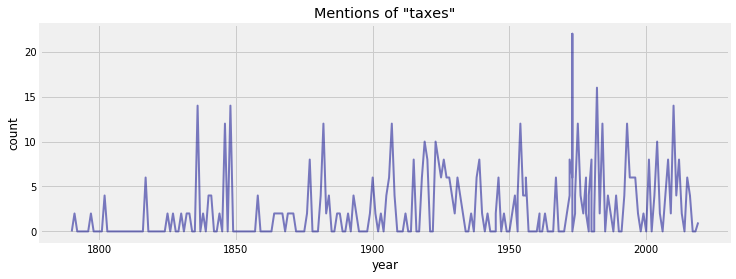

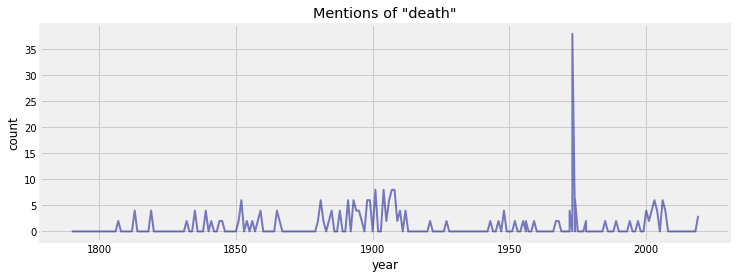

In [4]:
mentions_of_word('taxes', curve=True)
mentions_of_word('death', curve=True)

## 2. Pasting together all of the speeches for each President

Our next task is going to be to collect all of the SOTUs together for each individual president. To begin, let's think of how we might approach this using some `Table` operations. To make things easier to test, let's just form a small table that we can quickly manipulate.

In [5]:
presidents = speeches.drop('Date', 'Transcript').group(['President'], min).sort('Year min')
presidents.show()

President,Year min
George Washington,1790
John Adams,1797
Thomas Jefferson,1801
James Madison,1809
James Monroe,1817
John Quincy Adams,1825
Andrew Jackson,1829
Martin van Buren,1837
John Tyler,1841
James K. Polk,1845


Next we'll iterate through the presidents (flavors) and join together their speeches (varieties). We'll call the resulting table `collected_speeches`.

In [6]:
transcripts = []
for prez in presidents[0]:
    collected_transcripts = ' '.join(speeches.where('President', prez)[3])
    transcripts.append(collected_transcripts)
    
collected_speeches = Table().with_columns('President', presidents[0], 'SOTUs', transcripts)
collected_speeches.show()

President,SOTUs
George Washington,Fellow-Citizens of the Senate and House of Representativ ...
John Adams,Gentlemen of the Senate and Gentlemen of the House of Re ...
Thomas Jefferson,The Senate and House of Representatives of the United S ...
James Madison,Fellow-Citizens of the Senate and House of Representati ...
James Monroe,Fellow-Citizens of the Senate and House of Representati ...
John Quincy Adams,Fellow Citizens of the Senate and of the House of Repre ...
Andrew Jackson,Fellow Citizens of the Senate and of the House of Repre ...
Martin van Buren,Fellow-Citizens of the Senate and House of Representati ...
John Tyler,To the Senate and House of Representatives of the Unite ...
James K. Polk,Fellow-Citizens of the Senate and of the House of Repre ...


## 3. Plotting counts by president

This now makes it convient to modify our earlier `mentions_of_word` function to count the number of times a word is used by each president, across all of their speeches. The following function `presidents_mentions_of_word` is then a simple modification of our earlier function.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def presidents_mentions_of_word(word, show_table=False):
    count = []
    for i in np.arange(collected_speeches.num_rows):
        matches = re.findall('\s%s\s' % word, collected_speeches.column('SOTUs')[i])
        count.append(len(matches))
    
    sotu = collected_speeches.drop('SOTUs').with_columns('Count', count)
    if (show_table):
        sotu.show(42)
    return sotu


Now we'll make a bar plot of the word counts across the presidents. Let's try this out on the proverbial two things we can't avoid in life: death and taxes.

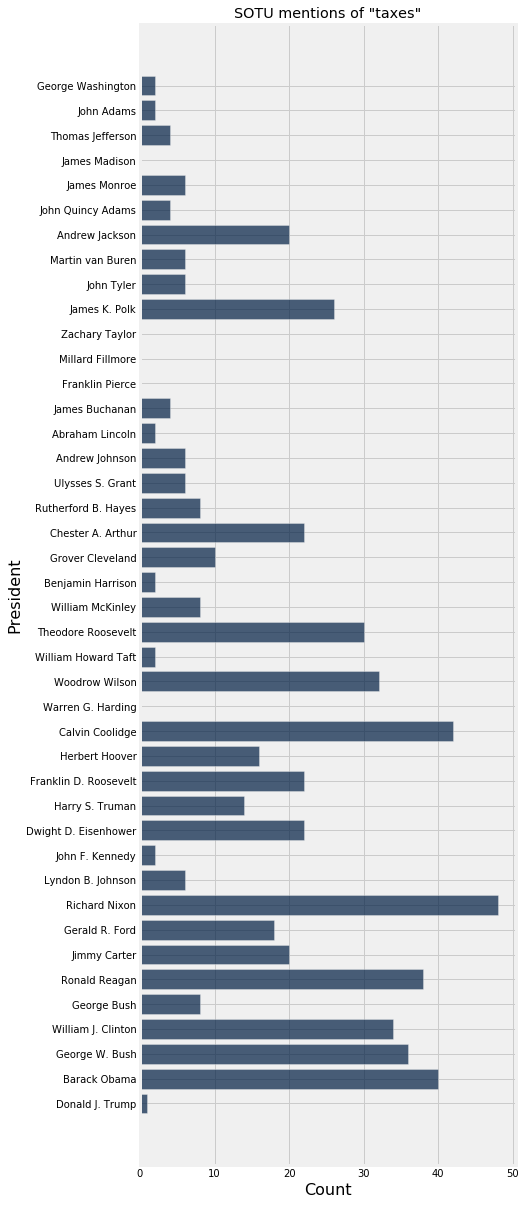

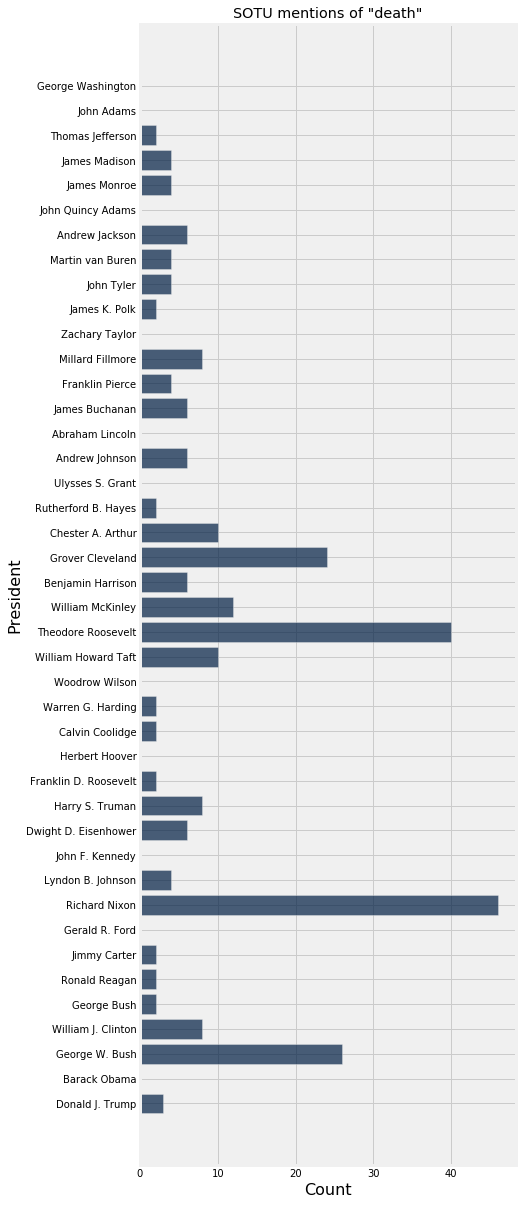

In [8]:
words = ['taxes', 'death']

for word in words:
    table = presidents_mentions_of_word(word, show_table=False)
    table.barh('President', 'Count')
    _ = plots.title('SOTU mentions of "%s"' % word)


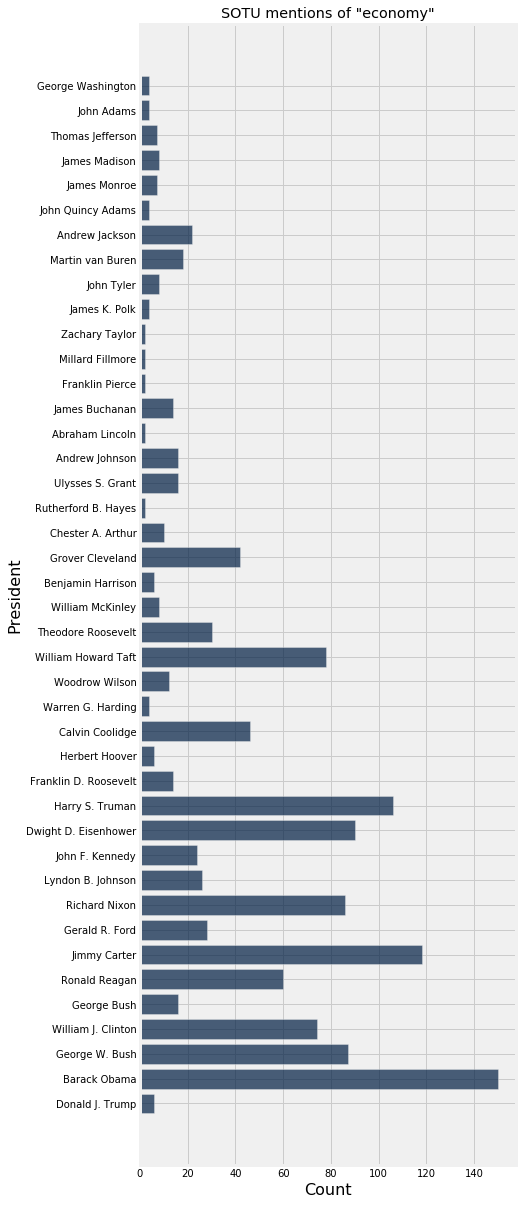

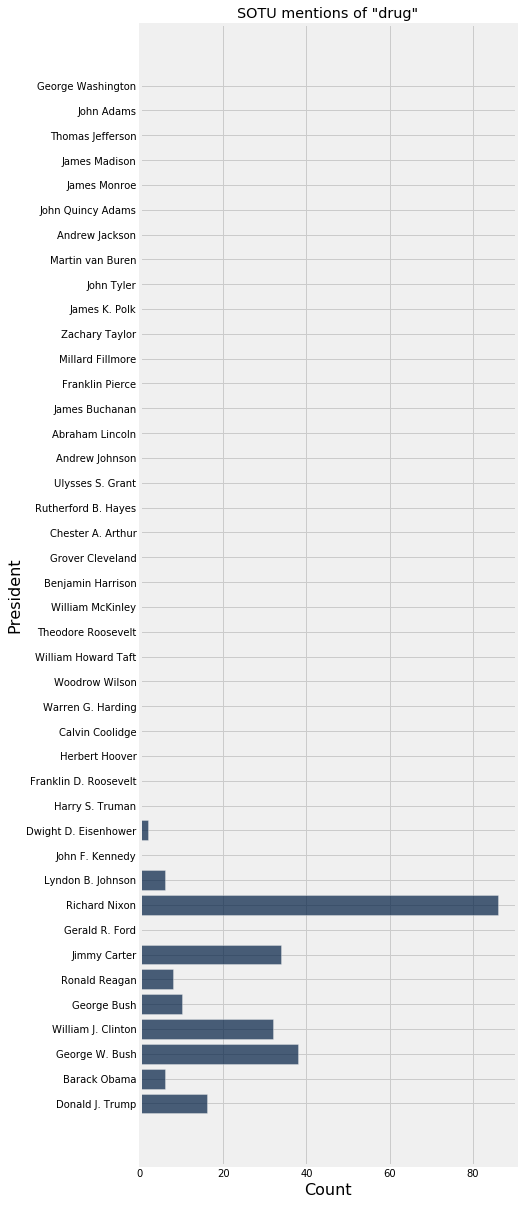

In [9]:
words = ['economy', 'drug']

for word in words:
    table = presidents_mentions_of_word(word, show_table=False)
    table.barh('President', 'Count')
    _ = plots.title('SOTU mentions of "%s"' % word)

## 4. Forming networks of Presidents

We're now going to plot some graphs after collecting data on which presidents mention which other presidents in their SOTUs. Think of it as kind of a SOTU Facebook.

This block of code first creates a table of presidents. Then, inside a for loop, each president is passed through the presidents_mentions_of_word function, which will compute the number of times each president has been mentioned in previous SOTU addresses. Finally, a table is created listing the amount of times each president mentions another president.  

In [10]:
table = Table().with_column('President', presidents[0])
for prez in presidents[0]:
    col = presidents_mentions_of_word(prez, show_table=False)
    table = table.with_column(prez, col[1])


Next, we're going to form a graph, or network, where the nodes are labeled by Presidents, and we have a directed edge from president $P_1$ to president $P_2$ if president $P_1$ mentions $P_2$ in any of his State of the Union addresses. So naturally, $P_2$ will have (almost certainly) served before $P_1$.

The next bit of code reads the table, and forms another table that we call `edge_table` corresponding to the nonzero entries, which will be the edges in our graph. Don't worry about the details; just execute this cell.


In [11]:
from_list = []
to_list = []
for i in np.arange(1,table.num_rows):
    for j in np.arange(len(table[i])):
        if table[i][j] > 0:
            from_list.append(table[0][j])
            to_list.append(table[0][i-1])

edge_table = Table().with_columns('From', from_list, 'To', to_list)
edge_table

From,To
Grover Cleveland,George Washington
Harry S. Truman,George Washington
Richard Nixon,George Washington
Gerald R. Ford,George Washington
Ronald Reagan,George Washington
William J. Clinton,George Washington
Barack Obama,George Washington
William McKinley,Thomas Jefferson
John F. Kennedy,Thomas Jefferson
Lyndon B. Johnson,Thomas Jefferson


Finally, the following code generates a graph (or network) using the `networkx` Python package. 


/Users/michaelchau/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/michaelchau/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


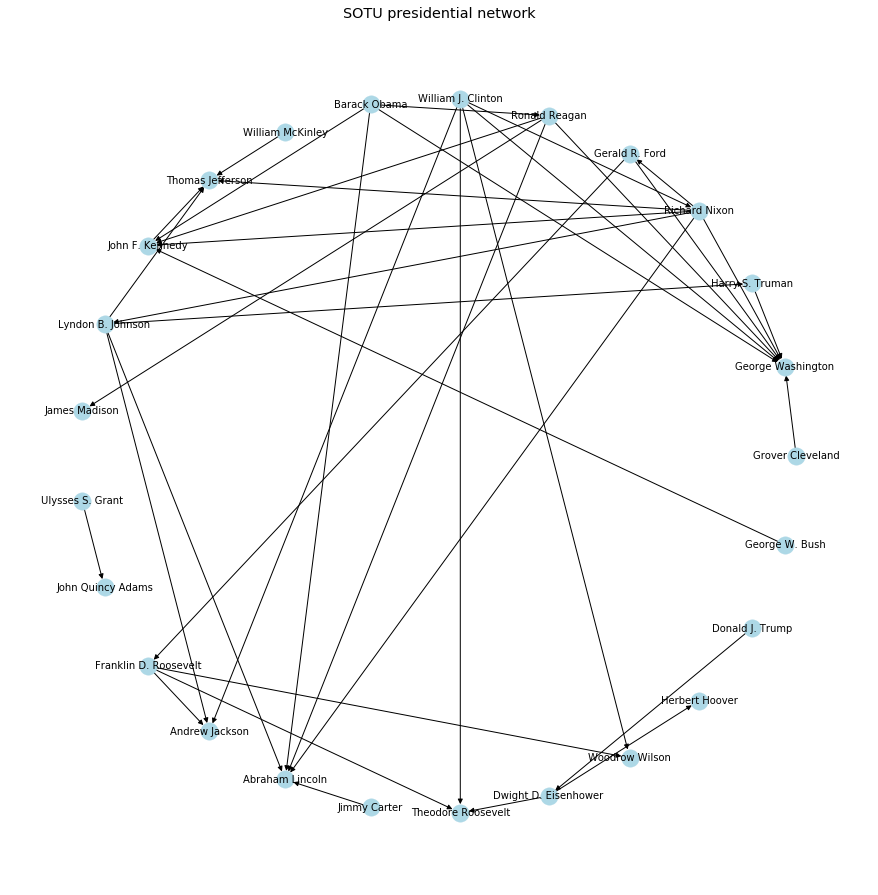

In [12]:
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

G = nx.DiGraph()
for i in np.arange(len(from_list)):
    G.add_edge(from_list[i], to_list[i])

# Plot it
fig = plt.figure()
fig.set_size_inches(12,12)
nx.draw_circular(G, with_labels=True, node_color='lightblue', font_size=10)
plt.title('SOTU presidential network')
plt.show()


## 5. Making a bipartite graph

Now let's display the same information in a different form. It will be presented as a "bipartite graph." This means there are two parts: Nodes on the left link to nodes on the right.


In [13]:
# function to draw bipartite from from list of edges of the form [(name0, name1), ...(name0, name1)]
def make_bipartite_graph(edges):
    new_edges = [(edge[0], edge[1]+' ') for edge in edges]
    from_list = {edge[0] for edge in new_edges}
    to_list = {edge[1] for edge in new_edges}

    G = nx.DiGraph()
    G.add_nodes_from(from_list, bipartite=0)
    G.add_nodes_from(to_list, bipartite=1)
    G.add_edges_from(new_edges)

    top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite']==0}
    bottom_nodes = set(G) - top_nodes


    l, r = nx.bipartite.sets(G, top_nodes)
    pos = {}
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    fig = plt.figure()
    fig.set_size_inches(12,12)
    nx.draw(G, pos=pos, with_labels=True, node_color='lightblue', alpha=0.9)
    plt.show()

    
    


Now generate the bipartite graph for "Presidential Facebook" by calling the function `make_bipartite_graph`. To do this, we first form a list of pairs $(P_1, P_2)$, by looping over the rows in `edge_table`. Then we pass in this list to `make_bipartite_graph`

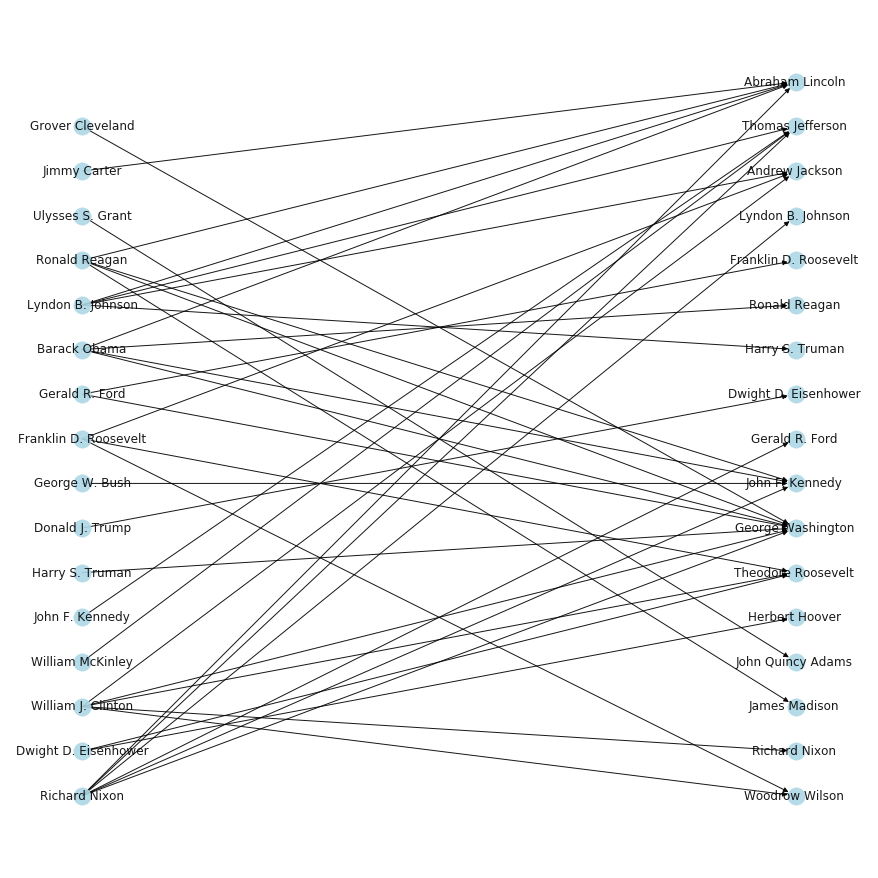

In [14]:
edge_list = [(edge_table[0][i], edge_table[1][i]) for i in np.arange(edge_table.num_rows)]
make_bipartite_graph(edge_list)


Here we will see which U.S. presidents mentioned "Gorbachev", "Churchill", "Stalin", "Lenin", "Hilter", and "Putin" in their SOTU addresses.

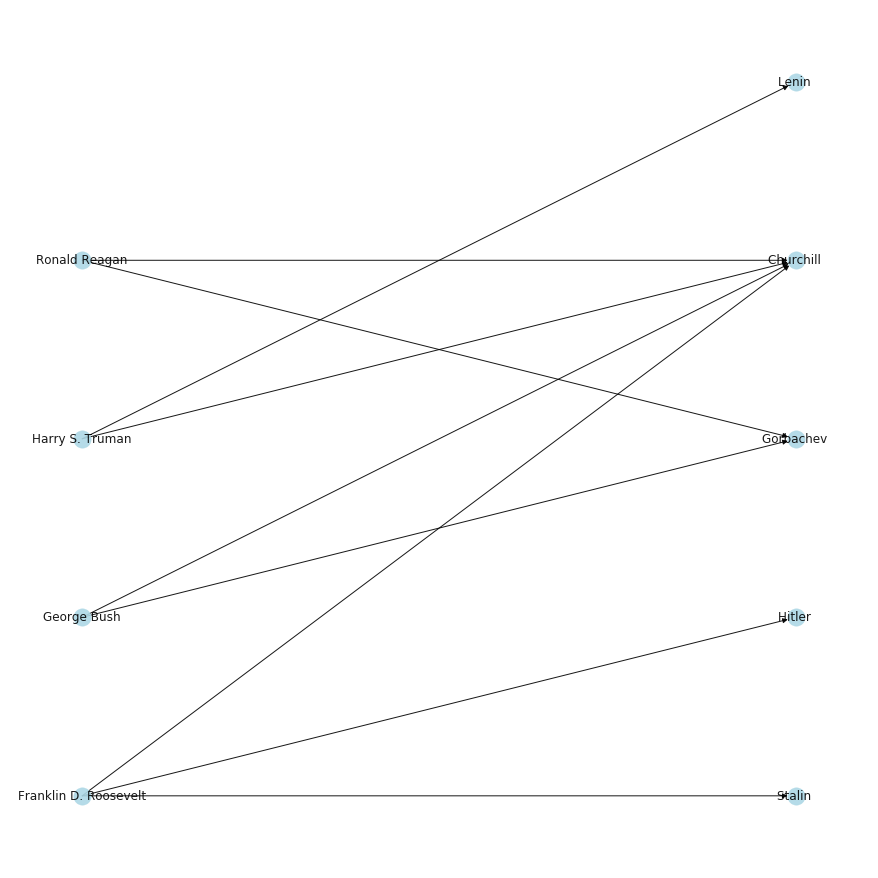

In [15]:
edge_list = []

for name in ['Gorbachev', 'Churchill', 'Stalin', 'Lenin', 'Hitler', 'Putin']:
    table = presidents_mentions_of_word(name)
    for prez in table.where('Count', are.above(0)).column('President'):
        edge_list.append((prez, name))

make_bipartite_graph(edge_list)

Here we will see which U.S. presidents mentioned 'Benjamin Franklin', 'Soviet Union', 'Iran', 'Camp David', 'White House', 'North Korea', 'Syria', 'Afghanistan', 'Ukraine', and 'Founding Fathers' in their SOTU addresses.

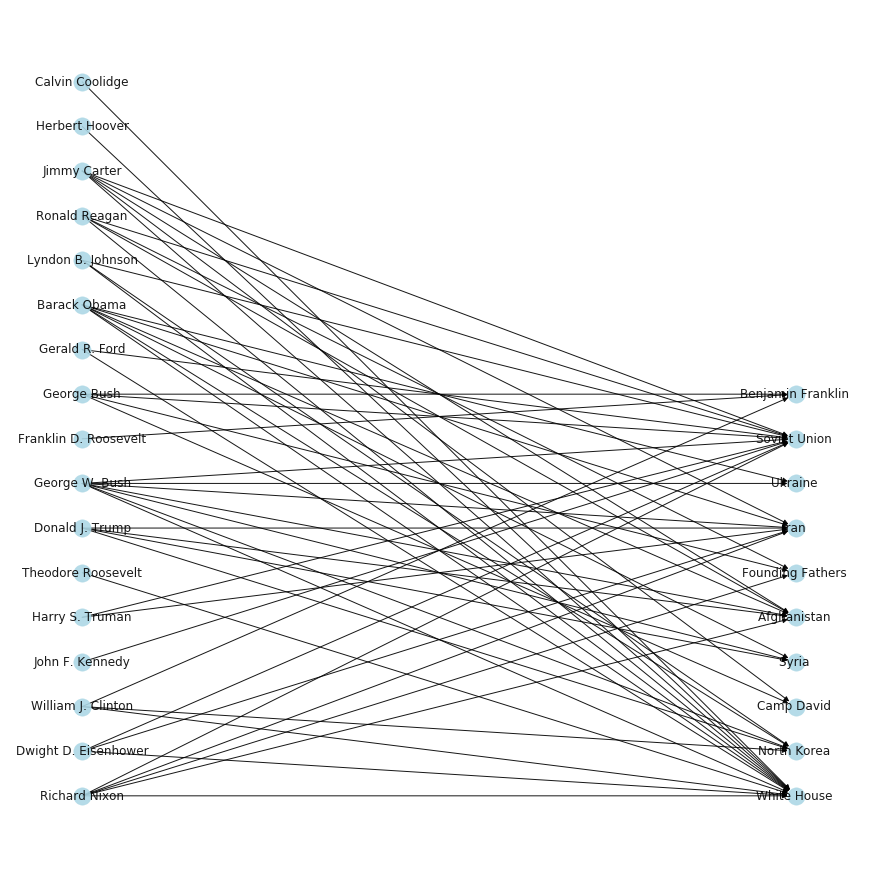

In [16]:
edge_list = []

for name in ['Benjamin Franklin', 'Soviet Union', 'Iran', 'Camp David', 'White House', 'North Korea', 'Syria', 'Afghanistan', 'Ukraine', 'Founding Fathers']:
    table = presidents_mentions_of_word(name)
    for prez in table.where('Count', are.above(0)).column('President'):
        edge_list.append((prez, name))

make_bipartite_graph(edge_list)